# Drift for evaluation metrics with bootstrap

This notebook shows a couple of examples of using the `bootstrap_eval_drift` function. This function allows to calculate the drift of a metric between two different sets. It performs bootstrapping in a source data set and a target dataset to obtain the distribution of some evaluation metric for both datasets. Then, it uses a drift detector to check if there is drift between both distributions of metrics.

There are two examples. The first example uses a synthetic time-series, while the second example is a classification problem using the wine dataset to classify high-quality wines.

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import math
import itertools
from mercury.monitoring.drift.metrics import bootstrap_eval_drift

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=2021)

## Example 1: Synthetic Timeseries

We create a synthetic time-series which consists of the next parts:

- <b>ts_train</b>: Data from January 2019 to June 2020. Used to train a model.

- <b>ts_test</b>: Data from July 2020 to September 2020. Used to validate the performance of a model. Follows the same pattern as `ts_train`

- <b>ts_prod_1</b>: Data from September 2020 to December 2020. It would represent data received when the model is already in production and is used to make predictions. Follows the same pattern as `ts_train` and `ts_test`

- <b>ts_prod_2</b>: Data from January  2021 to March 2021. It would represent a second batch of data received when the model is in production and used to make predictions. In this case, there a change in the pattern of the data

In [2]:

def generate_synthetic_ts(start_date='1/1/2018', end_date='31/12/2019', initial_value=1000, trend=0.5,
                         year_seasonalities=None, month_seasonalities=None, weekday_seasonalities=None,
                         noise_mean=0, noise_std=10):

    def add_seasonalities(ts, seasonalities, filter_col=None, prefix=''):
        for seas_name in seasonalities:
            col_name = prefix + seas_name
            seas = seasonalities[seas_name]
            ts[col_name] = 0
            filter_seas = ts[filter_col].isin(seas['filter_values'])
            ts.loc[filter_seas, col_name] = np.random.normal(
                loc=seas['mean'], scale=seas['scale'], size=len(ts[filter_seas]))
            ts["y"] += ts[col_name]
        return ts

    date_rng = pd.date_range(start=start_date, end=end_date, freq='D')
    ts = pd.DataFrame()
    # Calculate date
    ts["date"] = date_rng
    ts["weekday"] = ts["date"].dt.weekday
    ts["monthday"] = ts["date"].dt.day
    ts["month"] = ts["date"].dt.month
    # Initial value of timeseries
    ts["initial"] = initial_value
    ts["y"] = ts["initial"]
    # Trend
    ts["trend"] = np.arange(len(ts)) * trend
    ts["y"] += ts["trend"]
    # Seasonalities
    ts = add_seasonalities(ts, year_seasonalities, filter_col="month", prefix='year_seasonality_')
    ts = add_seasonalities(ts, month_seasonalities, filter_col="monthday", prefix='month_seasonality_')
    ts = add_seasonalities(ts, weekday_seasonalities, filter_col="weekday", prefix='wday_seasonality_')
    # Random noise
    ts["noise"] = np.random.normal(noise_mean, noise_std, size=len(ts))
    ts["y"] += ts["noise"]

    return ts

year_seasonalities = {}

month_seasonalities = {
    'end_month': {'mean': -15, 'scale': 0.5, 'filter_values': [25, 26, 27, 28, 29, 30, 31]}
}
weekdays_seasonalities = {
    'weekend': {'mean': 5, 'scale': 0.1, 'filter_values': [5, 6]}
}

start_train = datetime.datetime(2019, 1, 1)
end_train = datetime.datetime(2020, 6, 30)
ts_train = generate_synthetic_ts(
    start_date=start_train,
    end_date=end_train,
    initial_value=1000,
    trend=0.02,
    year_seasonalities=year_seasonalities,
    month_seasonalities=month_seasonalities,
    weekday_seasonalities=weekdays_seasonalities,
    noise_mean=0, noise_std=0.5)

start_test = datetime.datetime(2020, 7,1)
end_test = datetime.datetime(2020, 9, 30)
ts_test = generate_synthetic_ts(
    start_date=start_test,
    end_date=end_test,
    initial_value=ts_train.iloc[-1]["initial"] + ts_train.iloc[-1]["trend"] ,
    trend=0.02,
    year_seasonalities=year_seasonalities,
    month_seasonalities=month_seasonalities,
    weekday_seasonalities=weekdays_seasonalities,
    noise_mean=0, noise_std=0.5)

start_prod_1 = datetime.datetime(2020, 10,1)
end_prod_1 = datetime.datetime(2020, 12, 31)
ts_prod_1 = generate_synthetic_ts(
    start_date=start_prod_1,
    end_date=end_prod_1,
    initial_value=ts_test.iloc[-1]["initial"] + ts_test.iloc[-1]["trend"] ,
    trend=0.02,
    year_seasonalities=year_seasonalities,
    month_seasonalities=month_seasonalities,
    weekday_seasonalities=weekdays_seasonalities,
    noise_mean=0, noise_std=0.5)

start_prod_2 = datetime.datetime(2021, 1, 1)
end_prod_2 = datetime.datetime(2021, 3, 31)
ts_prod_2 = generate_synthetic_ts(
    start_date=start_prod_2,
    end_date=end_prod_2,
    initial_value=ts_prod_1.iloc[-1]["initial"] + ts_prod_1.iloc[-1]["trend"],
    trend=0.5,
    year_seasonalities=year_seasonalities,
    month_seasonalities=month_seasonalities,
    weekday_seasonalities=weekdays_seasonalities,
    noise_mean=0, noise_std=2)

df_ts = pd.concat([ts_train, ts_test, ts_prod_1, ts_prod_2])

When we visualize the time-series, we see that the pattern is very similar except for the last 3 months

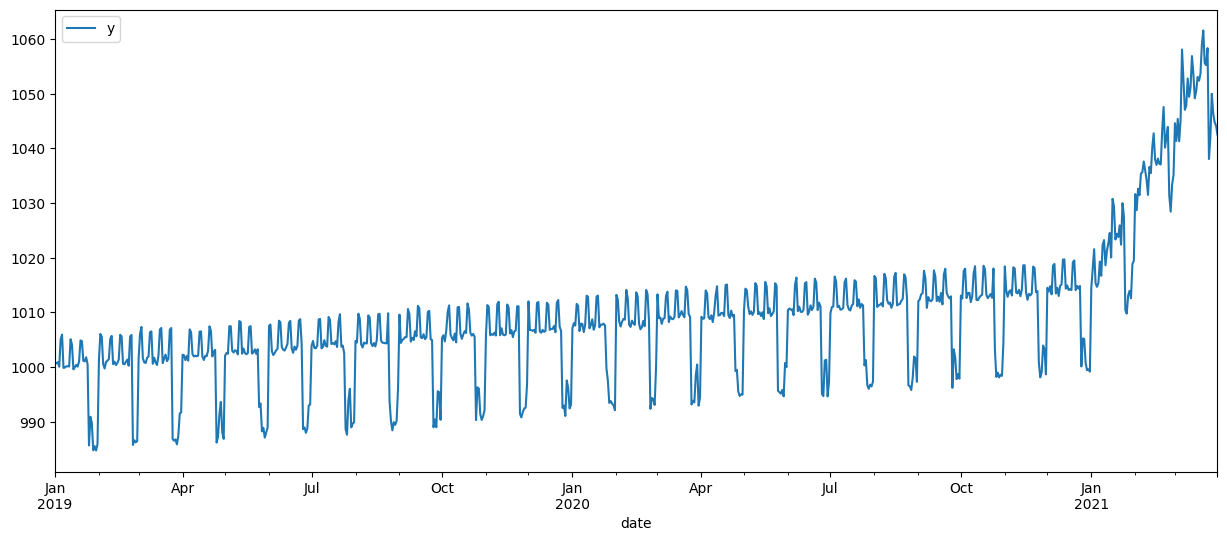

In [3]:
ax = df_ts.plot(x="date", y="y", figsize=(15,6))

### Train Model

Let's train a Linear regression model to predict the value of the next day of this time-series. We will use the next features:

- weekday: day of the week
- monthday: day of the month
- y_pred: value of the timeseries the previous day
- y_MA_7: moving average of the value of the timeseries the last 7 days
- y_MA_30: moving average of the value of the timeseries the last 30 days

In [5]:
def preprocess_df(df):
    df["y_prev"] = df["y"].shift(1)
    df['y_MA_7'] = df["y"].rolling(window=7).mean()
    df['y_MA_30'] = df["y"].rolling(window=30).mean()
    df = df.dropna()
    return df
    
features = ["weekday", "monthday", "y_prev", "y_MA_7", "y_MA_30"]

In [6]:
# Preprocess dataframe and separate them again
df_ts = preprocess_df(df_ts)

ts_train = df_ts[(df_ts["date"] >= start_train) & (df_ts["date"] <= end_train)].copy()
ts_test = df_ts[(df_ts["date"] >= start_test) & (df_ts["date"] <= end_test)].copy()
ts_prod_1 = df_ts[(df_ts["date"] >= start_prod_1) & (df_ts["date"] <= end_prod_1)].copy()
ts_prod_2 = df_ts[(df_ts["date"] >= start_prod_2) & (df_ts["date"] <= end_prod_2)].copy()

In [7]:
model = LinearRegression()
model = model.fit(ts_train[features], ts_train["y"])

In [8]:
model.coef_

array([ 0.94775616, -0.35475049,  0.35895623,  0.34169002,  0.29141431])

### Boostrap evaluation drift

Now we will calculate the drift for the evaluation metric by performing bootstrapping. 

We need to define an evaluation function that will return our metric. Our evaluation metric simply consists of the root mean squared error, but you could define any custom evaluation function that returns a float. 

In [9]:
def eval_rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_pred, y_true))

<b> Drift between test set and production_1 set </b>

Now, we calculate the drift of the evaluation metric in the test set and the production_1 set. We use the `bootstrap_eval_drift` function for that. This function returns the `drift_metrics` dictionary, the `drift_detector` object, and the `dist_src` and `dist_target` with the obtained metrics obtained with the bootstrap. Note that we do not specify the `drift_detector`, so by default, a `KSDrift` detector will be used we some default parameters. You can also create a `BaseBatchDriftDetector` object type and use it.

In [10]:
# Obtain predictions and labels for source dataset
y_pred_src = model.predict(ts_test[features])
y_true_src = ts_test["y"]

# Obtain predictiosn and labels for target dataset
y_pred_target = model.predict(ts_prod_1[features])
y_true_target = ts_prod_1["y"]

drift_metrics, drift_detector, dist_src, dist_target = bootstrap_eval_drift(
    y_true_src=y_true_src, y_pred_src=y_pred_src, y_true_target=y_true_target, y_pred_target=y_pred_target,
    resample_size_src=25, resample_size_target=25, num_resamples=1000,
    eval_fn=eval_rmse, drift_detector=None
)

print("Drift score: ", drift_metrics["score"])
print("Drift detected: ", drift_metrics["drift_detected"])


Drift score:  0.059
Drift detected:  False


We see that there is no drift between the metrics obtained from the test set and the production 1 set. We can check the distribution of the metric and see that they are quite similar:

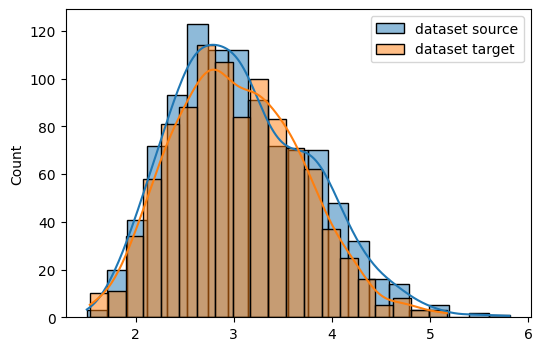

In [11]:
palette = itertools.cycle(sns.color_palette())

fig, ax = plt.subplots(1, 1, figsize=(6,4))

axes = sns.histplot(dist_src, kde=True, color=next(palette), ax=ax, label="dataset source")
axes = sns.histplot(dist_target, kde=True, color=next(palette), ax=ax, label="dataset target")
axes.legend()

<b> Drift between test and production 2 </b>

Now, let's do the same but between the test set and the production 2 set:

In [12]:
# Obtain predictions and labels for source dataset
y_pred_src = model.predict(ts_test[features])
y_true_src = ts_test["y"]

# Obtain predictiosn and labels for target dataset
y_pred_target = model.predict(ts_prod_2[features])
y_true_target = ts_prod_2["y"]


drift_metrics, drift_detector, dist_src, dist_target = bootstrap_eval_drift(
    y_true_src=y_true_src, y_pred_src=y_pred_src, y_true_target=y_true_target, y_pred_target=y_pred_target,
    resample_size_src=25, resample_size_target=25, num_resamples=1000,
    eval_fn=eval_rmse, drift_detector=None
)

print("Drift score: ", drift_metrics["score"])
print("Drift detected: ", drift_metrics["drift_detected"])

Drift score:  0.736
Drift detected:  True


We see now a higher drift score and drift has been detected. We can check the distribution of the metrics:

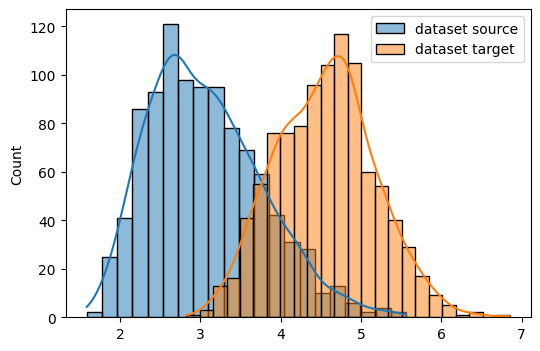

In [13]:
palette = itertools.cycle(sns.color_palette())

fig, ax = plt.subplots(1, 1, figsize=(6,4))

axes = sns.histplot(dist_src, kde=True, color=next(palette), ax=ax, label="dataset source")
axes = sns.histplot(dist_target, kde=True, color=next(palette), ax=ax, label="dataset target")
axes.legend()

As we have seen, we haven't identified drift when evaluating the model between the test set and the production 1 set. However, drift was identified between the test set and the production 2 set when evaluating the model. We can visualize the predictions in those 3 sets to obtain more insights:

In [14]:
def evaluate_and_visualize(ts):
    ts["y_pred"] = model.predict(ts[features])

    print("RMSE: ", eval_rmse(ts["y_pred"], ts["y"]))

    plt.figure(figsize=(10,4))
    plt.plot(ts["date"], ts["y"], label="true value")
    plt.plot(ts["date"], ts["y_pred"], label="prediction")
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

<b> Test </b>

RMSE:  3.1775411115903895


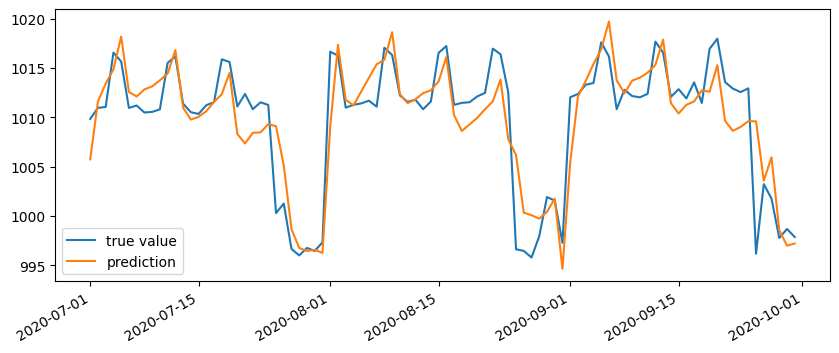

In [15]:
evaluate_and_visualize(ts_test)

<b> production_1 </b>

RMSE:  3.0918345618655785


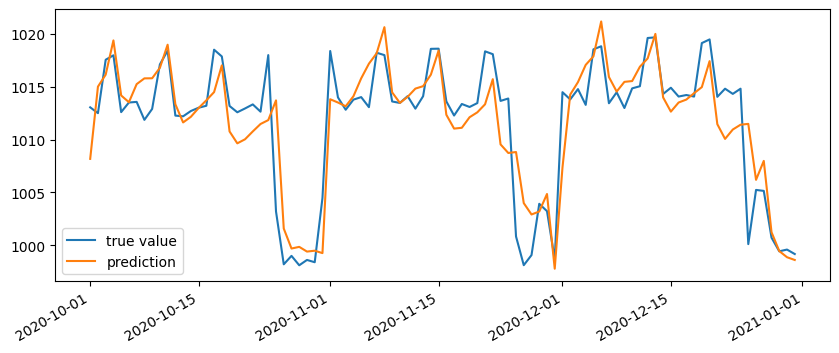

In [16]:
evaluate_and_visualize(ts_prod_1)

RMSE:  4.624117278024225


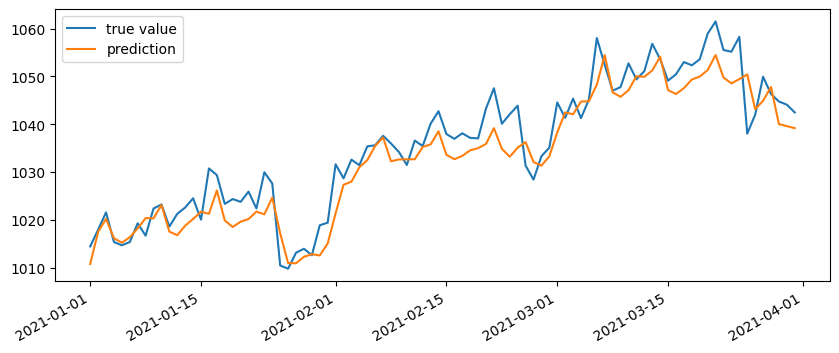

In [17]:
evaluate_and_visualize(ts_prod_2)

We see in general the predictions on the production 2 set are lower than the true value

## Example 2: Wine Dataset

Let's see now a second example using the wine quality dataset [[1]](#[1]). The files of this dataset are available inside of the /data/winequality folder in tutorials and it is also available in the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) 

Each row of the dataset represents a different wine and it contains attributes like the acidity of the wine or the level of alcohol. The dataset also contains the quality of the wine, ranging from 0 to 10. 


In [18]:
df_red_wines = pd.read_csv("../data/winequality/winequality-red.csv")
df_white_wines = pd.read_csv("../data/winequality/winequality-white.csv")

df_red_wines["type"] = "red"
df_white_wines["type"] = "white"

df = pd.concat([df_red_wines, df_white_wines])

### Experiment Setup

We convert this quality to an integer to indicate if it is a high-quality wine or not. We suppose that we have the goal of building a model to predict if a wine will be a high-quality wine given its attributes.


Importantly, to illustrate the drift functionalities and simulate a real situation we introduce a time column. This column represents the time when that wine is available. The important considerations to understand the setup are the next:
- The wines where time is equal to 0 represent the wines available for training a model. ALL these wines have a level of alcohol lower (or equal) than 11.
- We introduce new wines at each timestep. Different from the training set, these new wines can have a level of alcohol higher than 11. For each timestep, we proportion of wines with a higher level of alcohol than 11 grows. The total number of timesteps is 7.

In [19]:
# Create id
df["id"] = np.arange(df.shape[0])

# Encode Label
df["quality"] = df["quality"].apply(lambda x: 1 if x >=7 else 0)

# Encode Type
le = preprocessing.LabelEncoder()
df["type"] = le.fit_transform(df["type"])

# Set attribute to indicate high alcohol
df["high_alcohol"] = df["alcohol"].apply(lambda x: True if x > 11 else False)

# Time will represent the moment we have that data
df["time"] = -1

# For those rows with high alcohol, we set 70% of them as time 0 (they will be used as training)
df["time"] = df.apply(
    lambda x: 0 if (x["high_alcohol"] == False) and (np.random.uniform() < 0.7) else -1, axis=1
 )

# Each timestep, new amount of samples low_alcohol and high_alcohol
n_samples_low_alcohol = [500, 220, 200, 170, 120, 80, 30]
n_samples_high_alcohol = [0,    1,  10,  20,  40,  70, 150]
max_timesteps = 7
for t in range(1, max_timesteps + 1):
    # Sample examples with high_alcohol == True
    n_samples = n_samples_high_alcohol[t-1]
    sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == True)].sample(
        n_samples, random_state=0)["id"].values
    df.loc[df["id"].isin(sampled_ids), "time"] = t
    # Sample examples with high_alcohol == False
    n_samples = n_samples_low_alcohol[t-1]
    sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == False)].sample(
        n_samples, random_state=0)["id"].values
    df.loc[df["id"].isin(sampled_ids), "time"] = t 

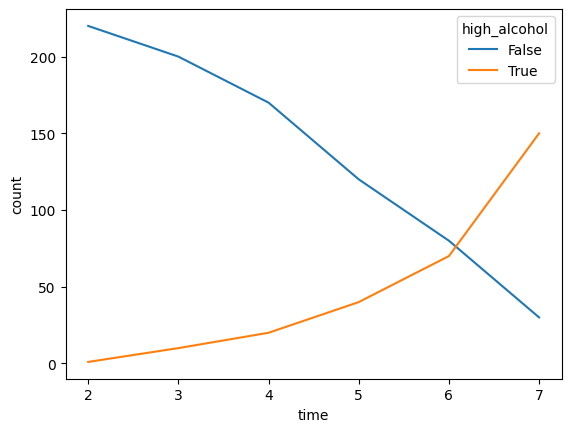

In [20]:
sample_counts = df.groupby(["time", "high_alcohol"])["id"].count().to_frame().reset_index()
sample_counts = sample_counts.rename(columns={"id": "count"})
sample_counts = sample_counts[sample_counts["time"] > 1]
ax = sns.lineplot(x="time", y="count", hue="high_alcohol", data=sample_counts)

### Train model with data at timestep 0

The initial dataset is the dataset with the wines at time 0. It represents the data available initially that we can use for training

In [21]:
df_initial = df[df["time"] == 0]

We split the initial dataset between train/test and train a Random Forest Classifier

In [22]:
from sklearn.model_selection import train_test_split

label = 'quality'
features = [c for c in df.columns if c not in [label, 'time', 'high_alcohol', 'id']]

X_initial = df_initial[features].values
y_initial = df_initial[label].values

X_train, X_test, y_train, y_test = train_test_split(X_initial, y_initial, test_size=0.3, random_state=42)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (2244, 12)
X_test:  (962, 12)
y_train:  (2244,)
y_test:  (962,)


In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=30, max_depth=4)
model = model.fit(X_train, y_train)

### Bootstrap drift of evaluation metric at several timesteps

Now we will calculate the drift for the evaluation metric by performing bootstrapping. 

In this case, our evaluation function will be just the accuracy. 

In [24]:
def eval_acc(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

Now, we will calculate the bootstrap drift of the evaluation metric for several timesteps. We check the drift score and if there is drift or not.

In [25]:
df_src = df[df["time"] == 1]
y_pred_src = model.predict(df_src[features])
y_true_src = df_src[label]

scores = []
for t in range(2, 8):
    
    df_t = df[df["time"] == t]

    y_pred_target = model.predict(df_t[features])
    y_true_target = df_t[label]

    drift_metrics, drift_detector, dist_src, dist_target = bootstrap_eval_drift(
        y_true_src=y_true_src, y_pred_src=y_pred_src, y_true_target=y_true_target, y_pred_target=y_pred_target,
        resample_size_src=25, resample_size_target=25, num_resamples=1000,
        eval_fn=eval_acc, drift_detector=None
    )
    scores.append(drift_metrics["score"])

    print("t = ", t, " Drift score: ", drift_metrics["score"], " Drift detected: ", drift_metrics["drift_detected"])

t =  2  Drift score:  0.069  Drift detected:  False
t =  3  Drift score:  0.423  Drift detected:  True
t =  4  Drift score:  0.377  Drift detected:  True
t =  5  Drift score:  0.44  Drift detected:  True
t =  6  Drift score:  0.837  Drift detected:  True
t =  7  Drift score:  0.88  Drift detected:  True


We see that drift is detected from almost the first moment. The amount of drift generally increases with the amount of wines with high alcohol

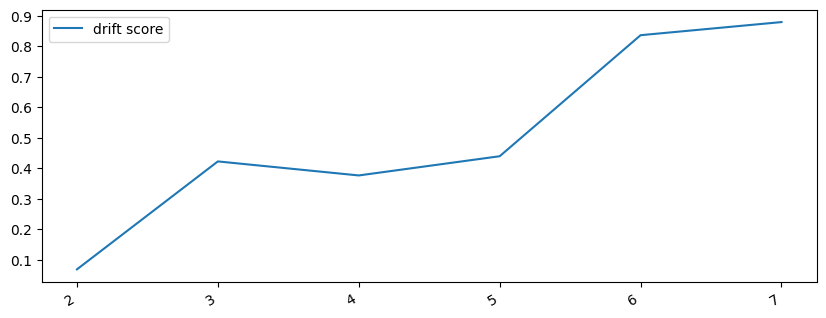

In [26]:
plt.figure(figsize=(10,4))
plt.plot(range(2,8), scores, label="drift score")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

# References

<a id="[1]">[1]</a> 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.